In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Conv2D, Activation, Dense, Lambda, Input, MaxPooling2D, Dropout, Flatten, Reshape, UpSampling2D, Concatenate
from keras.losses import mse, binary_crossentropy
from keras import backend as K
from keras.utils import plot_model, to_categorical

Using TensorFlow backend.


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((-1, 784)).astype('float32') / 255.0
x_test = x_test.reshape((-1, 784)).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


In [4]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [5]:
image_shape = (28, 28, 1)
original_dim = image_shape[0] * image_shape[1]
input_shape = (original_dim,)
batch_size = 128
latent_dim = 4
epochs = 20

# encoder
inputs = Input(shape=input_shape)
x = Reshape(image_shape)(inputs)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
label_inputs = Input(shape=(10,), name='label')
x = Concatenate()([latent_inputs, label_inputs])
x = Dense(128, activation='relu')(x)
x = Dense(14 * 14 * 32, activation='relu')(x)
x = Reshape((14, 14, 32))(x)
x = Dropout(0.25)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
outputs = Reshape(input_shape)(x)

decoder = Model([latent_inputs, label_inputs], outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# variational autoencoder
outputs = decoder([encoder(inputs)[2], label_inputs])
vae = Model([inputs, label_inputs], outputs, name='vae_mlp')
vae.summary()
plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [6]:
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [7]:
import os

weights_file = 'vae_cnn_mnist.h5'

if os.path.exists(weights_file):
    vae.load_weights(weights_file)
    print('Loaded weights!')
else:
    vae.fit([x_train, y_train],
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([x_test, y_test], None))
    vae.save_weights('vae_cnn_mnist.h5')

Loaded weights!


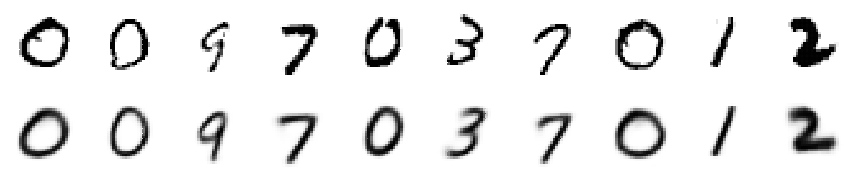

In [8]:
fig, axes = plt.subplots(2, 10, figsize=(15, 3))

def show(im):
    sns.heatmap(im.reshape((28, 28)), cmap='Greys', cbar=False, square=True, )

sample = np.random.randint(len(x_test), size=10)
reconst = vae.predict([x_test[sample], y_test[sample]])

for i in range(10):
    axes[0, i].get_xaxis().set_visible(False)
    axes[0, i].get_yaxis().set_visible(False)
    plt.sca(axes[0, i])
    show(x_test[sample[i]])
    axes[1, i].get_xaxis().set_visible(False)
    axes[1, i].get_yaxis().set_visible(False)
    plt.sca(axes[1, i])
    show(reconst[i])

plt.show()

In [9]:
from ipywidgets import interact, interact_manual

def from_latent(num, vec):
    vec = np.array(vec)
    im = decoder.predict([vec.reshape(1, latent_dim), to_categorical([num], 10)]).reshape(28, 28)
    return im

@interact(num=(0,9),
          x1=(-3., 3.), x2=(-3., 3.), x3=(-3., 3.), x4=(-3., 3.))
def f(num, x1, x2, x3, x4):
    plt.figure(2)
    plt.axis('off')
    im = from_latent(num, [x1, x2, x3, x4])
    sns.heatmap(im, square=True, cmap='Greys', cbar=False)
    plt.show()

Widget Javascript not detected.  It may not be installed or enabled properly.


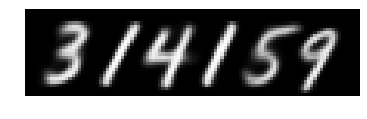

In [10]:
def digit_image(digit, latent=None):
    if latent is None:
        latent = np.random.randn(latent_dim)
    return from_latent(digit, latent)

def number_image(num):
    latent = 0.8 * np.random.randn(latent_dim)
    width = 16
    digits = str(num)
    result = np.zeros((28, width * len(digits) + (28 - width)))
    for i, d in enumerate(digits):
        result[:, width*i:width*i + 28] += digit_image(int(d), latent + 0.5 * np.random.randn(latent_dim))
    result = np.minimum(result, 1.0)
    return result

plt.gray()
plt.axis('off')
plt.imshow(number_image(314159))

In [11]:
def sample_images(num, rows=10, cols=5):
    images = []
    for i in range(rows):
        current = []
        for j in range(cols):
            current.append(number_image(num))
        images.append(np.concatenate(current, axis=1))
    return np.concatenate(images)

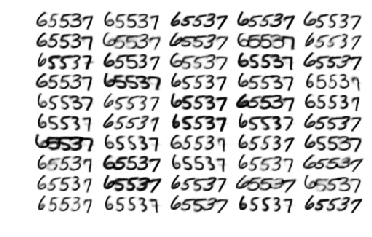

In [12]:
plt.gray()
plt.axis('off')
plt.imshow(1 - sample_images(65537))
plt.savefig('sample.png')